In [1]:
!pip install -q -U "tensorflow-text==2.13.*"

In [2]:
!pip install -q  "tf-models-official==2.13.*"

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
print("TF version: ", tf.__version__)
print("TF HUB version: ", hub.__version__)

TF version:  2.13.1
TF HUB version:  0.15.0


In [5]:
import pandas as pd
train_raw = pd.read_csv('consumer_complaints.csv')
train_raw.head()

<ipython-input-5-89021446fd77>:2: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  train_raw = pd.read_csv('consumer_complaints.csv')


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


Pre processing data

In [6]:
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

<Axes: ylabel='Frequency'>

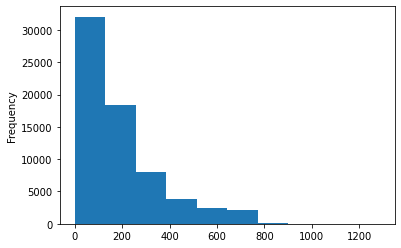

In [7]:
train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split())).plot(kind='hist')

In [8]:

train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [9]:

train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [10]:
train_raw = train_raw[['consumer_complaint_narrative', 'product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [11]:

train_raw.loc[train_raw['product'] == 'Credit reporting', 'product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.loc[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.loc[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.loc[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.loc[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [12]:
import numpy as np
for l in np.unique(train_raw['product']):
  print(l)

Bank account or service
Consumer Loan
Credit card or prepaid card
Credit reporting, credit repair services, or other personal consumer reports
Debt collection
Money transfers
Mortgage
Other financial service
Payday loan, title loan, or personal loan
Student loan


<Axes: xlabel='product'>

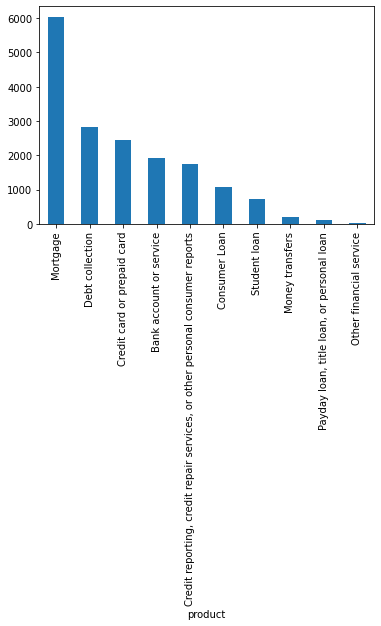

In [13]:

train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [14]:

train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [15]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()
     

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [16]:

len(np.unique(train_raw['label']))

10

In [17]:
train = train_raw.copy()
     

In [18]:

train = train.reindex(np.random.permutation(train.index))
train.head()


,text,label
12106,I want to begin by stating the following story...,4
16486,"On XXXX XXXX, 2014 I went to Herbies Auto Sale...",1
14722,We have a loan modification with a shared appr...,6
3729,During the process of applying for a home equi...,0
8395,In the XX/XX/XXXX I totaled my vehicle. It was...,1


In [19]:
import re
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\W)+"," ",text)    
  return text

In [20]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
12106,I want to begin by stating the following story...,4
16486,On XXXX XXXX 2014 I went to Herbies Auto Sales...,1
14722,We have a loan modification with a shared appr...,6
3729,During the process of applying for a home equi...,0
8395,In the XX XX XXXX I totaled my vehicle It was ...,1


In [21]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()
     

,text,label
2063,Disputed Date of XXXX Delinquency regarding XX...,3
9811,My brother in law and I jointly own a condo in...,6
709,i attended XXXX XXXX Pennsylvania for diesel a...,9
12070,I recently received a mortgage modification de...,6
8599,I am a XXXX and have a property listed for sal...,6


In [22]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,Disputed Date of XXXX Delinquency regarding XX...,3
1,My brother in law and I jointly own a condo in...,6


In [23]:
val.reset_index(drop=True, inplace=True)
val.head(2)
     

,text,label
0,My complaint is for XXXX of XXXX PA once a par...,9
1,on or about XXXX XXXX i sent credit XXXX a let...,3


In [24]:
# Set the output directory for saving model file
OUTPUT_DIR = './bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: ./bert_news_category *****


In [25]:
val.shape, train.shape

((3429, 2), (13713, 2))

In [26]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [28]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,Disputed Date of XXXX Delinquency regarding XX...,3,[Disputed Date of XXXX Delinquency regarding X...
1,My brother in law and I jointly own a condo in...,6,[My brother in law and I jointly own a condo i...
2,i attended XXXX XXXX Pennsylvania for diesel a...,9,[i attended XXXX XXXX Pennsylvania for diesel ...
3,I recently received a mortgage modification de...,6,[I recently received a mortgage modification d...
4,I am a XXXX and have a property listed for sal...,6,[I am a XXXX and have a property listed for sa...


In [29]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,text,label,text_split
0,My complaint is for XXXX of XXXX PA once a par...,9,[My complaint is for XXXX of XXXX PA once a pa...
1,on or about XXXX XXXX i sent credit XXXX a let...,3,[on or about XXXX XXXX i sent credit XXXX a le...


In [30]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(31693, 31693, 31693)

In [31]:

val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)
     

(7932, 7932, 7932)

In [32]:

train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()
     

,text,label
0,Disputed Date of XXXX Delinquency regarding XX...,3
1,thing happened with another credit bureau and ...,3
2,My brother in law and I jointly own a condo in...,6
3,XXXX mo of income I also had another rental pr...,6
4,i attended XXXX XXXX Pennsylvania for diesel a...,9


In [33]:

val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,My complaint is for XXXX of XXXX PA once a par...,9
1,on or about XXXX XXXX i sent credit XXXX a let...,3
2,Wells Fargo Dealer Services provided financing...,1
3,situation took a turn for the worse and within...,1
4,was able to show that their situation had impr...,1


In [34]:
train_df = train_df[:500]
len(train_df)

500

In [35]:
val_df = val_df[:100]
len(val_df)

100

In [36]:
#!conda install pytorch torchvision torchaudio -c pytorch-nightly -y


In [37]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [38]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encoded_data = tokenizer.batch_encode_plus(train_df.text.values, add_special_tokens=True, return_attention_mask=True, truncation=True, pad_to_max_length=True, max_length=256, return_tensors='pt')
input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(train_df.label.values)

# Load the pre-trained BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10, output_attentions=False, output_hidden_states=False)

# Define the training parameters
batch_size = 32
epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# Train the model
for epoch in range(epochs):
    model.train()
    for i in range(0, input_ids.size(0), batch_size):
        optimizer.zero_grad()
        outputs = model(input_ids[i:i+batch_size], attention_mask=attention_masks[i:i+batch_size], labels=labels[i:i+batch_size])
        loss = outputs.loss
        loss.backward()
        optimizer.step()

# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_masks)
    predictions = torch.argmax(outputs[0], dim=1).flatten()
    accuracy = torch.sum(predictions == labels) / len(labels)

print("Accuracy:", accuracy.item())


/Users/deepu_rajan/anaconda3/envs/bert2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/deepu_rajan/anaconda3/envs/bert2/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classif

Accuracy: 0.5320000052452087


In [39]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,My complaint is for XXXX of XXXX PA once a par...,9
1,on or about XXXX XXXX i sent credit XXXX a let...,3
2,Wells Fargo Dealer Services provided financing...,1
3,situation took a turn for the worse and within...,1
4,was able to show that their situation had impr...,1


LSTM: Creating the Final Model

In [40]:
vocab_size = 5000
embedding_dim = 64
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .8

In [41]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'xxxx': 2,
 'the': 3,
 'i': 4,
 'to': 5,
 'and': 6,
 'my': 7,
 'a': 8,
 'that': 9,
 'of': 10}

In [42]:
train_sequences = tokenizer.texts_to_sequences(train_df["text"])

In [43]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [44]:
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

200
200
159
200
200
200


In [45]:
validation_sequences = tokenizer.texts_to_sequences(val_df["text"])
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

7932
(7932, 200)


In [46]:


training_label_seq = np.array(train_df["label"])
validation_label_seq = np.array(val_df["label"])
print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

3
3
6
(500,)
9
3
1
(7932,)


In [47]:
model = tf.keras.Sequential([
    # Add an Embedding layer expecting input vocab of size 5000, and output embedding dimension of size 64 we set at the top
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    # use ReLU in place of tanh function since they are very good alternatives of each other.
    tf.keras.layers.Dense(embedding_dim, activation='relu'),
    # Add a Dense layer with 6 units and softmax activation.
    # When we have multiple outputs, softmax convert outputs layers into a probability distribution.
    tf.keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          320000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 394954 (1.51 MB)
Trainable params: 394954 (1.51 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
16/16 - 13s - loss: 2.2494 - accuracy: 0.3220 - val_loss: 2.0901 - val_accuracy: 0.3744 - 13s/epoch - 808ms/step
Epoch 2/10
16/16 - 7s - loss: 1.8767 - accuracy: 0.3840 - val_loss: 1.8663 - val_accuracy: 0.3744 - 7s/epoch - 427ms/step
Epoch 3/10
16/16 - 7s - loss: 1.7405 - accuracy: 0.3840 - val_loss: 1.8490 - val_accuracy: 0.3744 - 7s/epoch - 426ms/step
Epoch 4/10
16/16 - 7s - loss: 1.6814 - accuracy: 0.3840 - val_loss: 1.8344 - val_accuracy: 0.3744 - 7s/epoch - 430ms/step
Epoch 5/10
16/16 - 7s - loss: 1.6165 - accuracy: 0.3840 - val_loss: 1.7749 - val_accuracy: 0.3746 - 7s/epoch - 429ms/step
Epoch 6/10
16/16 - 7s - loss: 1.3903 - accuracy: 0.5560 - val_loss: 1.7018 - val_accuracy: 0.4595 - 7s/epoch - 428ms/step
Epoch 7/10
16/16 - 7s - loss: 1.2106 - accuracy: 0.6800 - val_loss: 1.6662 - val_accuracy: 0.3839 - 7s/epoch - 427ms/step
Epoch 8/10
16/16 - 7s - loss: 0.9984 - accuracy: 0.7460 - val_loss: 1.6121 - val_accuracy: 0.4502 - 7s/epoch - 427ms/step
Epoch 9/10
16/16 - 7s 

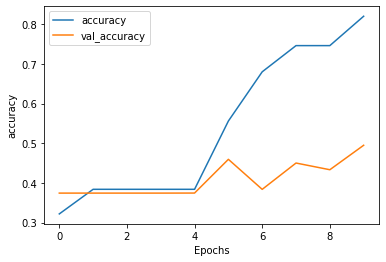

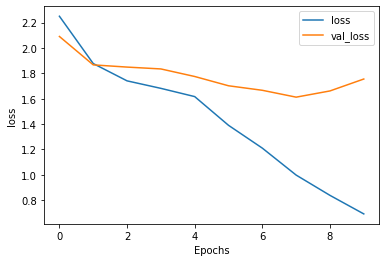

In [49]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")